#  Project - Indoor Localization using Wi-Fi Fingerprinting

### UJIINDOORLOC WLAN MAIN CHARACTERISTICS

- Covers a surface of 108,703m2 – 3 buildings with 4 or 5 floors. 
- 933 different places (reference points) appeared in the database. 
- 19,938 sample points were obtained for training/learning and 1,111 were obtained for validation/testing – 21,049 in total. 
- Testing samples were taken 4 months after the training samples to ensure dataset independence. 
- 520 different WAPs (Wireless Access Points) appeared in the database. 
- Data collected by more than 20 users with 25 different mobile device models.

### import library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler # normalisation
from sklearn.model_selection import train_test_split # split

from sklearn import svm

import time as time 
import pickle as pickle
import glob as glob

# Modelling
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBClassifier, XGBRegressor
#from catboost import CatBoostClassifier, CatBoostRegressor

from scipy.stats import randint as sp_randint, uniform as sp_uniform

from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, mean_squared_error

from joblib import dump, load
from sklearn.decomposition import PCA

### Functions used

In [2]:
#--- save data ---#
def save_data(dataframe, filename):
    file_present = glob.glob(filename) # boolean, file already present?
    if not file_present:
        dataframe.to_csv(filename)
    else:
        print('WARNING: This file already exists.')
        
def saveList(myList,filename):
    file_present = glob.glob(filename) # boolean, file already present?
    if not file_present:     
        np.save(filename,myList) # the filename should mention the extension 'npy'
        print("Saved successfully!")
    else:
        print('WARNING: This file already exists.')
    
def loadList(filename):
    file_present = glob.glob(filename) # boolean, file already present?
    if not file_present:
        print('WARNING: This file dose not exists.')
    else:
        tempNumpyArray=np.load(filename)# the filename should mention the extension 'npy'
    return tempNumpyArray.tolist()

#--- save best model ---#
def save_model(model, model_name):
    model_name_present = glob.glob(model_name) # boolean
    if not model_name_present:
        pickle.dump(grid_result, open(model_name, 'wb'))
    else:
        print('WARNING: This file already exists.')

### Data Analysis

In [3]:
# training/validation set
train_set = pd.read_csv("UJIndoorLoc/trainingData.csv")

# test set
test_set  = pd.read_csv("UJIndoorLoc/validationData.csv")

#### Evaluate Data (training/validation) 

In [4]:
print("-- shape of train_set is : {}".format(train_set.shape))
print("-- shape of test_set is  : {}".format(test_set.shape))

-- shape of train_set is : (19937, 529)
-- shape of test_set is  : (1111, 529)


In [5]:
train_set.head(5)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [6]:
train_set.columns.values[500:]

array(['WAP501', 'WAP502', 'WAP503', 'WAP504', 'WAP505', 'WAP506',
       'WAP507', 'WAP508', 'WAP509', 'WAP510', 'WAP511', 'WAP512',
       'WAP513', 'WAP514', 'WAP515', 'WAP516', 'WAP517', 'WAP518',
       'WAP519', 'WAP520', 'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID',
       'SPACEID', 'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP'],
      dtype=object)

In [7]:
print("-----------train_set------------")
train_set.info()
print("-----------test_set------------")
test_set.info()

-----------train_set------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 80.5 MB
-----------test_set------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 4.5 MB


#### Variables

- there are three buildings 0, 1, and 2
- 4 floors for building 0
- 4 floors for building 1
- 5 floors for building 2

In [8]:
#Viewing data sample (non-WAP columns)
train_set_without_inputs = train_set[[x for x in train_set.columns if 'WAP' not in x]]
#Viewing data sample (with-WAP columns)
train_set_with_inputs    = train_set[[x for x in train_set.columns if 'WAP' in x]]

num_building = train_set['BUILDINGID'].unique() # there are three building 0, 1, and 2
num_floor_buildingZero = train_set.loc[train_set["BUILDINGID"] == 0]["FLOOR"].unique() #building 0 has 4 floors
num_floor_buildingOne  = train_set.loc[train_set["BUILDINGID"] == 1]["FLOOR"].unique() #building 1 has 4 floors
num_floor_buildingTwo  = train_set.loc[train_set["BUILDINGID"] == 2]["FLOOR"].unique() #building 2 has 5 floors

#### Statistical summary

In [9]:
train_set_without_inputs.describe()

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-7691.338400,4.864746e+06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,-7594.737000,4.864821e+06,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,-7423.060900,4.864852e+06,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,-7359.193000,4.864930e+06,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,-7300.818990,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


#### missing values

- No missing values

In [10]:
# check for missing values
print("missing values for train_set: {}".format(pd.isna(train_set).values.any())) 
print("missing values for test_set:  {}".format(pd.isna(test_set).values.any())) 

missing values for train_set: False
missing values for test_set:  False


#### Number of records by building

In [11]:
num_records_building_train = train_set.pivot_table(values='TIMESTAMP', index=['BUILDINGID'], aggfunc='count')
num_records_building_train.rename(columns={"TIMESTAMP": "RECORDS"})

,RECORDS
BUILDINGID,
0,5249
1,5196
2,9492


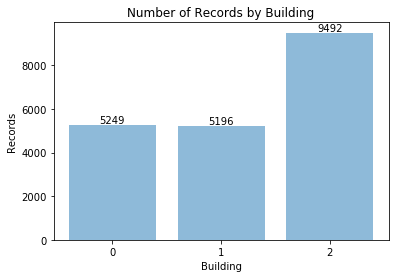

In [12]:
plt.bar(num_records_building_train.index, num_records_building_train["TIMESTAMP"], alpha=0.5)
plt.xlabel("Building")
plt.ylabel("Records")
plt.xticks(range(0,len(num_records_building_train.index)))
plt.title('Number of Records by Building')
for x , y in zip(num_records_building_train.index,num_records_building_train["TIMESTAMP"]): 
    plt.text(x,y,y,ha='center',va='bottom')# adjusting them
plt.show()

#### Number of records by building & floors

In [13]:
num_floors_buildings_records = train_set.pivot_table(values='TIMESTAMP', index=['FLOOR'],
                                                 columns='BUILDINGID', aggfunc='count')

#num_floors_buildings_records = (num_floors_buildings_records/num_floors_buildings_records.sum())*100
num_floors_buildings_records = num_floors_buildings_records.replace(np.NaN, 0)
num_floors_buildings_records

BUILDINGID,0,1,2
FLOOR,,,
0,1059.0,1368.0,1942.0
1,1356.0,1484.0,2162.0
2,1443.0,1396.0,1577.0
3,1391.0,948.0,2709.0
4,0.0,0.0,1102.0


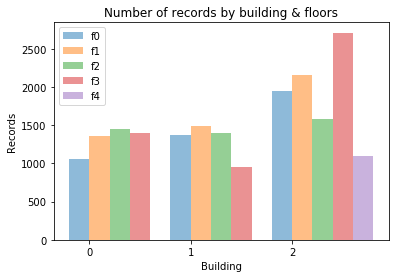

In [132]:
barWidth = 0.2
building_num = train_set["BUILDINGID"].sort_values(ascending=True).unique()
f1 = building_num
f2 = [x + barWidth for x in f1]
f3 = [x + barWidth for x in f2]
f4 = [x + barWidth for x in f3]
f5 = [x + barWidth for x in f4]
plt.bar(f1, num_floors_buildings_records.loc[0,:], width = barWidth, alpha=0.5, label='f0')
plt.bar(f2, num_floors_buildings_records.loc[1,:], width = barWidth, alpha=0.5, label='f1')
plt.bar(f3, num_floors_buildings_records.loc[2,:], width = barWidth, alpha=0.5, label='f2')
plt.bar(f4, num_floors_buildings_records.loc[3,:], width = barWidth, alpha=0.5, label='f3')
plt.bar(f5, num_floors_buildings_records.loc[4,:], width = barWidth, alpha=0.5, label='f4')
plt.legend()
plt.xlabel("Building")
plt.ylabel("Records")
plt.title('Number of records by building & floors')
r = range(len(building_num))
plt.xticks([r + barWidth / 2 for r in range(len(num_floors_buildings_records.loc[0,:]))], ['0', '1', '2'])
plt.show()

#### Number of records by longitude and latitude and building

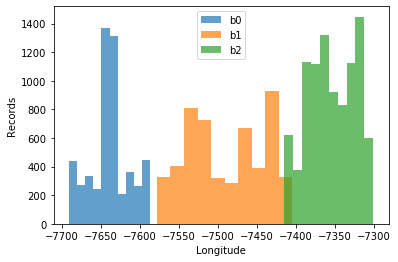

In [15]:
plt.hist(train_set[train_set["BUILDINGID"] ==0]["LONGITUDE"], label='b0', alpha=0.7)
plt.hist(train_set[train_set["BUILDINGID"] ==1]["LONGITUDE"], label='b1', alpha=0.7)
plt.hist(train_set[train_set["BUILDINGID"] ==2]["LONGITUDE"], label='b2', alpha=0.7)
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Records")
plt.show()

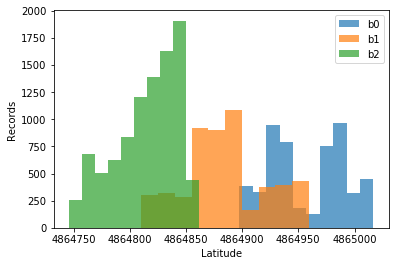

In [16]:
plt.hist(train_set[train_set["BUILDINGID"] ==0]["LATITUDE"], label='b0', alpha=0.7)
plt.hist(train_set[train_set["BUILDINGID"] ==1]["LATITUDE"], label='b1', alpha=0.7)
plt.hist(train_set[train_set["BUILDINGID"] ==2]["LATITUDE"], label='b2', alpha=0.7)
plt.legend()
plt.xlabel("Latitude")
plt.ylabel("Records")
plt.show()

#### Number of records by longitude and latitude per building

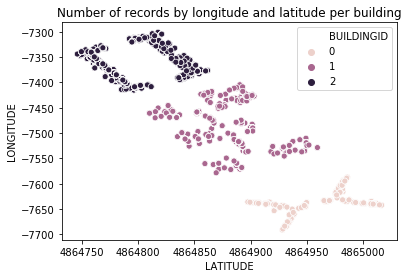

In [129]:
sns.scatterplot(x='LATITUDE', y='LONGITUDE', data = train_set, hue="BUILDINGID")
plt.title('Number of records by longitude and latitude per building')
plt.show()

In addition to examining the target variables, a quick sense check is conducted on the input variables as well.¶

-    Due to high dimensionality (520 WAP columns), the variables are condensed to a single column per record - highest signal strength across all WAP
-    Adds additional layer of analysis based on factors not considered by mere count of records - e.g. how does height of user / phone used / building floor affect signal strength
-    Might help explain any variance in prediction models - e.g. higher accuracy for certain buildings & floors

Maximum RSSI of the WAPs - check whether any WAPs have no recorded data; aids in feature selection for modelling

#### Condensing input variables into single column - max_signal

In [18]:
#search the max signal
#signal take on integer values ranging from -104 (weak) to 0 (strong), 
#with a value of 100 representing no signal detected (replace 100 by undefined values).

train_set_without_inputs_maxSig = train_set_without_inputs
train_set_without_inputs_maxSig['MAXSIGNAL'] = train_set_with_inputs.replace(100,np.NaN).max(axis=1)
train_set_without_inputs_maxSig.head(5)

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,MAXSIGNAL
0,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733,-53.0
1,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691,-46.0
2,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095,-61.0
3,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807,-55.0
4,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710,NaN


As seen in Row 4 of the sample table, some records do not have any max_signal strength - all WAPs for that record received no RSSI reading (denoted as 100 in this dataset). These rows are not automatically filtered out as they might provide additional insights and be essential to modelling.

### Examining records with no RSSI readings (NaN records)

#### Number of NaN Records per Building

In [19]:
train_set_without_inputs_maxSig_building_nan = \
    train_set_without_inputs_maxSig.loc[np.isnan(train_set_without_inputs_maxSig['MAXSIGNAL']),] #week signals
train_set_without_inputs_maxSig_building_nan =\
    train_set_without_inputs_maxSig_building_nan.groupby(['BUILDINGID']).TIMESTAMP.count().reset_index()
train_set_without_inputs_maxSig_building_nan.rename(columns={"TIMESTAMP": "RECORDS"})
train_set_without_inputs_maxSig_building_nan

,BUILDINGID,TIMESTAMP
0,0,1
1,1,37
2,2,38


In [20]:
print("Number of records with no RSSI readings (i.e. NaN records): %i (%.2f%%)" % \
      (train_set_without_inputs_maxSig_building_nan.TIMESTAMP.sum(), 
     (train_set_without_inputs_maxSig_building_nan.TIMESTAMP.sum()/len(train_set)*100)))

Number of records with no RSSI readings (i.e. NaN records): 76 (0.38%)


- Number of records with no RSSI readings (i.e. NaN records): 76 (0.38%)

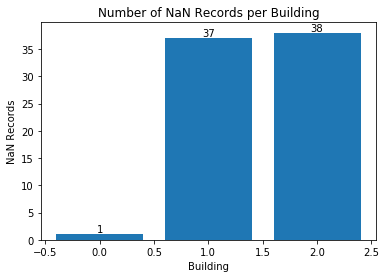

In [21]:
plt.bar(train_set_without_inputs_maxSig_building_nan.BUILDINGID, \
        train_set_without_inputs_maxSig_building_nan.TIMESTAMP)
plt.xlabel("Building")
plt.ylabel("NaN Records")
plt.title('Number of NaN Records per Building')
for x , y in \
    zip(train_set_without_inputs_maxSig_building_nan.BUILDINGID,\
        train_set_without_inputs_maxSig_building_nan.TIMESTAMP): 
    plt.text(x,y,y,ha='center',va='bottom')# adjusting them
plt.show()

#### Number of NaN Records per Building and Floor

In [22]:
train_set_without_inputs_maxSig_floor_building_nan = \
        train_set_without_inputs_maxSig.pivot_table(values='TIMESTAMP', index=['FLOOR'],
                                                 columns='BUILDINGID', aggfunc='count')
train_set_without_inputs_maxSig_floor_building_nan = \
        train_set_without_inputs_maxSig_floor_building_nan.replace(np.NaN, 0)
train_set_without_inputs_maxSig_floor_building_nan

BUILDINGID,0,1,2
FLOOR,,,
0,1059.0,1368.0,1942.0
1,1356.0,1484.0,2162.0
2,1443.0,1396.0,1577.0
3,1391.0,948.0,2709.0
4,0.0,0.0,1102.0


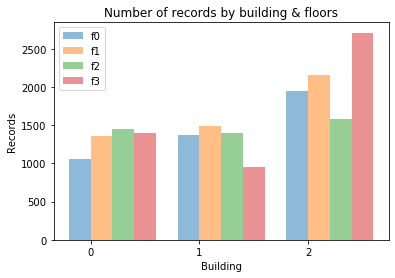

In [131]:
barWidth = 0.2
building_num = train_set["BUILDINGID"].sort_values(ascending=True).unique()
f1 = building_num
f2 = [x + barWidth for x in f1]
f3 = [x + barWidth for x in f2]
f4 = [x + barWidth for x in f3]
f5 = [x + barWidth for x in f4]
plt.bar(f1, train_set_without_inputs_maxSig_floor_building_nan.loc[0,:], width = barWidth, alpha=0.5, label='f0')
plt.bar(f2, train_set_without_inputs_maxSig_floor_building_nan.loc[1,:], width = barWidth, alpha=0.5, label='f1')
plt.bar(f3, train_set_without_inputs_maxSig_floor_building_nan.loc[2,:], width = barWidth, alpha=0.5, label='f2')
plt.bar(f4, train_set_without_inputs_maxSig_floor_building_nan.loc[3,:], width = barWidth, alpha=0.5, label='f3')
#plt.bar(f5, train_set_without_inputs_maxSig_floor_building_nan.loc[4,:], width = barWidth, alpha=0.5, label='f4')
plt.legend()
plt.xlabel("Building")
plt.ylabel("Records")
plt.title('Number of records by building & floors')
r = range(len(building_num))
plt.xticks([r + barWidth / 2 for r in range(len(num_floors_buildings_records.loc[0,:]))], ['0', '1', '2'])

plt.show()

#### Number of records per user

In [24]:
train_set_userID_TimeTamp = train_set_without_inputs_maxSig.groupby(['USERID']).TIMESTAMP.count().reset_index()
train_set_userID_TimeTamp

,USERID,TIMESTAMP
0,1,2737
1,2,1091
2,3,192
3,4,374
4,5,610
5,6,980
6,7,1383
7,8,507
8,9,1066
9,10,913


In [25]:
#data base for week signals
train_set_without_inputs_maxSig_nan = \
                    train_set_without_inputs_maxSig.loc[np.isnan(train_set_without_inputs_maxSig['MAXSIGNAL']),]
print("shape of train_set_without_inputs_maxSig_nan: {}".format(train_set_without_inputs_maxSig_nan.shape))

shape of train_set_without_inputs_maxSig_nan: (76, 10)


- distribution of NaN records per user

In [26]:
train_set_without_inputs_maxSig_users_nan =\
                train_set_without_inputs_maxSig_nan.groupby(['USERID']).TIMESTAMP.count().reset_index()
train_set_without_inputs_maxSig_users_nan

,USERID,TIMESTAMP
0,7,1
1,8,59
2,11,2
3,17,14


In [27]:
train_set_without_inputs_maxSig_users_nan_percent =\
                train_set_without_inputs_maxSig_nan.groupby(['USERID']).TIMESTAMP.count().reset_index()
total =train_set_without_inputs_maxSig_users_nan_percent['TIMESTAMP'].sum()
train_set_without_inputs_maxSig_users_nan_percent['TIMESTAMP'] = train_set_without_inputs_maxSig_users_nan_percent['TIMESTAMP'].apply(lambda x: "%.2f%%" % ((x/total)*100))
train_set_without_inputs_maxSig_users_nan_percent.rename(columns={"TIMESTAMP": "RECORDS"})

,USERID,RECORDS
0,7,1.32%
1,8,77.63%
2,11,2.63%
3,17,18.42%


Majority of the NaN records originate from User 8

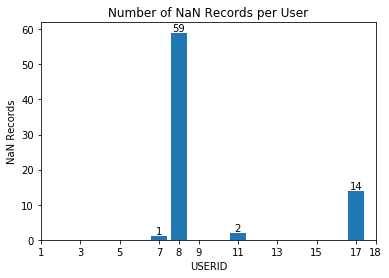

In [28]:
plt.bar(train_set_without_inputs_maxSig_users_nan.USERID, 
        train_set_without_inputs_maxSig_users_nan.TIMESTAMP)
plt.xlabel("USERID")
plt.ylabel("NaN Records")
plt.xticks([1, 3, 5, 7, 8, 9, 11,13, 15, 17, 18])
plt.title('Number of NaN Records per User')
for x , y in \
        zip(train_set_without_inputs_maxSig_users_nan.USERID,train_set_without_inputs_maxSig_users_nan.TIMESTAMP): 
    plt.text(x,y,y,ha='center',va='bottom')# adjusting them
plt.show()

#### Geographical Distribution of NaN Records

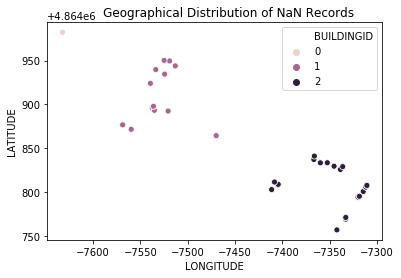

In [29]:
#lat-long scatter plot
sns.scatterplot(x='LONGITUDE', y='LATITUDE', data = train_set_without_inputs_maxSig_nan, hue="BUILDINGID")
plt.title('       Geographical Distribution of NaN Records')
plt.show()

- Geographical distribution shows few concentrated clusters

#### Number of NaN records within VALIDATION set

In [30]:
test_set_maxSig = test_set[[x for x in test_set.columns if 'WAP' not in x]]
test_set_maxSig['MAXSIGNAL'] = test_set.loc[:,[x for x in test_set.columns if 'WAP' in x]].replace(100,np.NaN).max(axis=1)

test_set_maxSig_nan = test_set_maxSig['MAXSIGNAL'].isnull().sum()
print("Number of NaN records within VALIDATION set: %i (%.2f%%)" % (test_set_maxSig_nan, (test_set_maxSig_nan/len(test_set)*100)))

Number of NaN records within VALIDATION set: 0 (0.00%)


### Removing data

In [31]:
#train_set_without_inputs_maxSig = train_set_without_inputs
#train_set_without_inputs_maxSig['MAXSIGNAL'] = train_set_with_inputs.replace(100,np.NaN).max(axis=1)
#train_set_without_inputs_maxSig.head(5)

#tab2 = pd.DataFrame([[8,2,3], [8,5,6], [8,8,8], [8,8,10], [8,8,8]], columns=['aa','ab','ac'])
#tab2 = tab2.replace(8,np.NaN) 
#tab2['m'] = tab2.max(axis=1)
#tab2

In [32]:
nan_rows_index = train_set_without_inputs_maxSig_nan.index.to_list()
train = train_set.iloc[[x for x in train_set.index if x not in nan_rows_index]]
wap_max = train[[x for x in train.columns if 'WAP' in x]].replace(100,np.nan).max(axis=0).reset_index()
wap_max = wap_max.rename(columns={'index':'wap_name', 0: 'max_signal'}).fillna(10)

cols_torm = wap_max.loc[wap_max['max_signal']==10,'wap_name'].tolist()
train = train.drop(train[cols_torm],axis=1)
test = test_set.drop(test_set[cols_torm],axis=1)

print('Number of WAP variables removed: {}'.format(len(cols_torm)))
print('Remaining WAP variables: {}'.format(len([x for x in train.columns if 'WAP' in x])))

Number of WAP variables removed: 55
Remaining WAP variables: 465


# Predictive Modelling

### Classification Algorithms
Input variables: WAP001 to WAP520

Excluding the 55 WAP variables with no RSSI readings
Target variables: Building and Floor

Total classes: 13 (cross join of all available buildings and floors)

In [33]:
# Creates single variable combining both targets
train['target'] = 'B' + train['BUILDINGID'].astype(str) + '_F' + train['FLOOR'].astype(str)
test['target']  = 'B' + test['BUILDINGID'].astype(str) + '_F' + test['FLOOR'].astype(str)
train['target'].unique()

array(['B1_F2', 'B2_F3', 'B2_F4', 'B2_F2', 'B1_F0', 'B1_F1', 'B2_F1',
       'B1_F3', 'B2_F0', 'B0_F0', 'B0_F2', 'B0_F1', 'B0_F3'], dtype=object)

In [34]:
#Step 1: Algorithm selection

#    A mixture of linear and non-linear models are selected
#    Using 5-fold cross validation to evaluate which model has the highest accuracy

In [35]:
# class_models = []
# class_models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
# class_models.append(('Decision Tree', DecisionTreeClassifier(random_state=20)))
# class_models.append(('Random Forest', RandomForestClassifier(random_state=20)))
# class_models.append(('Neural Network', MLPClassifier(random_state=20)))
# class_models.append(('XGBoost', XGBClassifier(random_state=20)))
# #class_models.append(('CatBoost', CatBoostClassifier(silent=True,iterations=200,random_seed=20)))

# #evaluate each model in turn
# class_results   = []
# class_names     = []
# cv_results_mean = []
# cv_results_std  = []
# for name, model in class_models:
#     st = time.time()
#     kfold = KFold(n_splits=5, random_state=20)
#     cv_results = cross_val_score(model, train[[x for x in train.columns if 'WAP' in x]], train['target'].ravel(), cv=kfold, scoring='accuracy',n_jobs=-1)
#     class_results.append(cv_results)
#     class_names.append(name)
#     cv_results_mean
#     print("{}: {:.4f} ({:.4f})".format(name, cv_results.mean(), cv_results.std()))
#     print("\tTime elapsed: {:.2f} seconds".format(time.time()-st))

In [116]:
#saveList(class_results, 'class_results_classifier_allModels.npy')
#saveList(class_names, 'class_names_classifier_allModels.npy')
class_results = loadList('class_results_classifier_allModels.npy') 
class_names = loadList('class_names_classifier_allModels.npy')
class_names

['Linear Discriminant Analysis',
 'Decision Tree',
 'Random Forest',
 'Neural Network',
 'XGBoost']

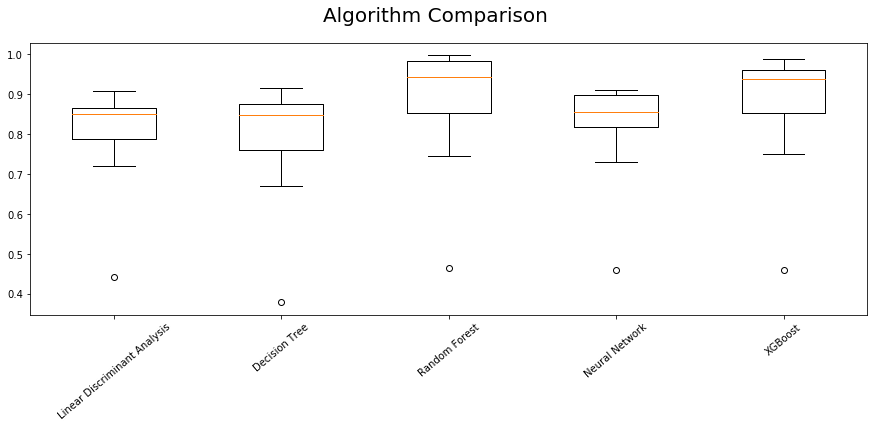

In [37]:
# Compare Algorithms
fig = plt.figure(figsize=(15,5))
fig.suptitle('Algorithm Comparison',fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(class_results)
ax.set_xticklabels(class_names,rotation=40)
plt.show()

- XGBoost and Random Forest are highest average accuracy, hence will be the model selected for the classification.

#### XGBoost Model - classification

In [102]:
# st = time.time()
# original_class_params = {
#  "learning_rate":0.1,
#  "n_estimators":100,
#  "max_depth":5,
#  "min_child_weight":1,
#  "gamma":0,
#  "alpha":0,
#  "lambda":1,
# }
# class_xg = XGBClassifier(**original_class_params,objective="multi:softmax",num_classes=13,seed=20,n_jobs=-1)
# class_xg.fit(train[[x for x in train.columns if 'WAP' in x]], train['target'].ravel())
# class_preds = class_xg.predict(test[[x for x in train.columns if 'WAP' in x]])
# print("Accuracy: {:.2f}%".format(accuracy_score(test['target'].ravel(), class_preds)*100))
# print("\tTime elapsed: {:.2f} seconds".format(time.time()-st))

In [103]:
#save model 
#dump(class_xg, 'XGB_Base_Classifier.joblib')
#load model
class_xg = load('XGB_Base_Classifier.joblib')

In [104]:
#saveList(class_preds.tolist(),'class_preds_base_XGBClassifier.npy')
class_preds = loadList('class_preds_base_XGBClassifier.npy')
class_preds = np.asarray(class_preds)
print("Accuracy: {:.2f}%".format(accuracy_score(test['target'].ravel(), class_preds)*100))

Accuracy: 87.67%


Confusion Matrix:



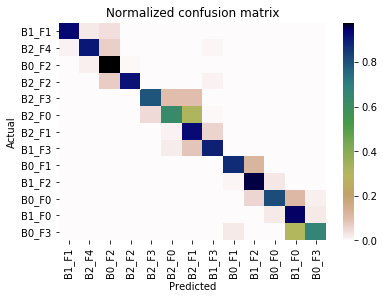

In [105]:
class_cm = confusion_matrix(test['target'].ravel(), class_preds)
normed_cm = (class_cm.T / class_cm.astype(np.float).sum(axis=1)).T
print("Confusion Matrix:\n")
sns.heatmap(normed_cm, cmap=plt.cm.gist_earth_r, xticklabels=test['target'].unique(), yticklabels=test['target'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized confusion matrix')
plt.show(block=False)

##### XGBClassifier Model improvements (using RandomizedSearchCV)

In [106]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=200)


principalComponents = pca.fit_transform(train[[x for x in train.columns if 'WAP' in x]])
x_train = pd.DataFrame(data = principalComponents)
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-225.012332,145.107422,57.703623,-21.105366,-208.961537,359.819554,-124.458775,-240.215492,-188.791530,-37.274631,...,-14.992918,-3.074324,-1.698032,16.610010,4.032453,11.096516,-21.801732,-0.519773,-39.988661,-16.264172
1,-217.119552,133.495682,54.755079,-16.321641,-192.694063,327.530983,-113.463078,-209.964229,-162.982229,-45.314330,...,1.214083,-4.457884,-0.580059,5.807821,-10.997638,4.889506,-7.887751,-3.476576,15.680911,-4.412378
2,-203.681392,136.012022,46.070713,14.062182,-207.298503,304.326270,-75.033063,-316.488160,-205.155479,10.381463,...,9.573159,38.022494,-12.155501,3.505540,-3.168037,8.554642,-3.154171,-15.513608,-21.064907,-2.402665
3,-225.023013,132.381827,60.843658,30.761679,-184.976753,271.069347,-89.638268,-332.687240,-169.382479,31.410514,...,-15.979678,-30.616193,9.865168,1.626636,22.119791,-7.911714,10.713951,18.190017,-2.123691,-4.814913
4,-215.667788,90.413360,38.210511,-14.249895,-176.934682,272.045184,-85.350311,-302.530789,-180.457055,-1.546475,...,-4.409186,-21.319448,-2.017219,-4.581116,6.562757,-0.446114,7.667967,7.663493,6.874011,6.171959


In [107]:
# XGBoost to get best hyperparameter grid
# st = time.time()
# random_grid = {
# "learning_rate": sp_uniform(0.2,0.25),
# "max_depth": sp_randint(3,5),
# "min_child_weight": sp_randint(3,5),
# "n_estimators": sp_randint(390,400),
# "gamma": sp_randint(0,1),
# "objective": ["multi:softmax","multi:softprob"],
# }
# #Gridsearch with 3-fold validation
# class_xg_random = RandomizedSearchCV(estimator=class_xg,param_distributions=random_grid,n_iter=10,verbose=2,\
#                                      random_state=5,n_jobs=-1)
# #Fit the random search model
# #class_xg_random.fit(train[[x for x in train.columns if 'WAP' in x]], train['target'].ravel())
# class_xg_random.fit(x_train, train['target'].ravel())
# print("\tTime elapsed: {:.2f} seconds".format(time.time()-st))

In [108]:
#save model 
#dump(class_xg_random, 'class_xg_random_Classifier.joblib')
#load model
class_xg_random = load('class_xg_random_Classifier.joblib')

In [109]:
best_hp_dict = class_xg_random.best_params_
best_hp_dict

{'gamma': 0,
 'learning_rate': 0.27117147016034093,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 390,
 'objective': 'multi:softmax'}

In [110]:
## Compare aganst original model
base_accuracy = accuracy_score(test['target'].ravel(), class_preds)
random_accuracy = class_xg_random.best_score_
print('Base accuracy: {:.2f}%'.format(base_accuracy*100))
print('Best accuracy from Randomized Search: {:.2f}%'.format(random_accuracy*100))
print('Improvement of {:.2f}%'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Base accuracy: 87.67%
Best accuracy from Randomized Search: 91.25%
Improvement of 4.09%


##### Using the hyperparameters that produces the highest accuracy, the model is tuned to produce the following results:

In [111]:
#xg_tuned = XGBClassifier(**best_hp_dict,seed=20)
#xg_tuned.fit(train[[x for x in train.columns if 'WAP' in x]], train['target'].ravel())
#class_preds_tuned = xg_tuned.predict(test[[x for x in train.columns if 'WAP' in x]])

In [112]:
#saveList(class_preds_tuned.tolist(), 'class_preds_tuned_XGBClassifier.npy')
class_preds_tuned = np.asarray(loadList('class_preds_tuned_XGBClassifier.npy'))

Confusion Matrix:



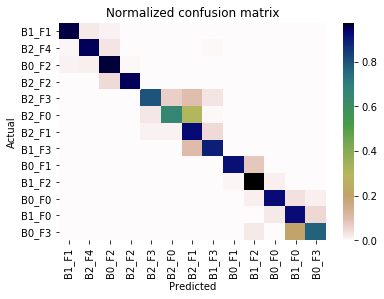

In [113]:
class_cm = confusion_matrix(test['target'].ravel(), class_preds_tuned)
normed_cm = (class_cm.T / class_cm.astype(np.float).sum(axis=1)).T
print("Confusion Matrix:\n")
sns.heatmap(normed_cm, cmap=plt.cm.gist_earth_r, xticklabels=test['target'].unique(), yticklabels=test['target'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized confusion matrix')
plt.show(block=False)

##### Evaluation Model

In [114]:
class_results = pd.concat([test[['target']], 
                          pd.DataFrame(columns=['Predicted'],
                                      data=class_preds),
                          pd.DataFrame(columns=['Predicted_Tuned'],
                                      data=class_preds_tuned)],axis=1)
class_results = class_results.apply(lambda x: x.str.split('_'))
class_results['pred_building'] = class_results.apply(lambda row: row['target'][0] == row['Predicted'][0], axis=1)
class_results['pred_floor']    = class_results.apply(lambda row: row['target'][1] == row['Predicted'][1], axis=1)
class_results['pred_tuned_building'] = class_results.apply(lambda row: row['target'][0] == row['Predicted_Tuned'][0], axis=1)
class_results['pred_tuned_floor'] = class_results.apply(lambda row: row['target'][1] == row['Predicted_Tuned'][1], axis=1)

org_bldg = class_results['pred_building'].sum()/len(class_results)
org_floor = class_results['pred_floor'].sum()/len(class_results)
tuned_bldg = class_results['pred_tuned_building'].sum()/len(class_results)
tuned_floor = class_results['pred_tuned_floor'].sum()/len(class_results)
print('With original predictions, the percentage of correctly classified BUILDINGS = {:.2f}%'.format(org_bldg*100))
print('With original predictions, the percentage of correctly classified FLOORS = {:.2f}%'.format(org_floor*100))
print()
print('With TUNED predictions, the percentage of correctly classified BUILDINGS = {:.2f}% ({:.2f}% improvement)'.format((tuned_bldg*100),((tuned_bldg-org_bldg)/org_bldg*100)))
print('With TUNED predictions, the percentage of correctly classified FLOORS = {:.2f}% ({:.2f}% improvement)'.format((tuned_floor*100),((tuned_floor-org_floor)/org_floor*100)))


With original predictions, the percentage of correctly classified BUILDINGS = 99.73%
With original predictions, the percentage of correctly classified FLOORS = 87.76%

With TUNED predictions, the percentage of correctly classified BUILDINGS = 99.91% (0.18% improvement)
With TUNED predictions, the percentage of correctly classified FLOORS = 90.10% (2.67% improvement)


#### Random Forest Model - classification

In [98]:
#Random Forest to get best hyperparameter grid
st = time.time()
hyperparameters = {'criterion': ['gini'], 
                  'max_depth': [None], 
                  'max_features': ['sqrt'],
                  'n_estimators': [60]}
scoring = {'accuracy': 'accuracy'}    

grid = GridSearchCV(estimator = RandomForestClassifier(random_state=20), 
                        param_grid = hyperparameters,
                        scoring = scoring,
                        cv = 10,
                        refit = 'accuracy', # what best model is based on, and specifies that the best model 
                                            # will be refitted on the whole training set
                        return_train_score = True,
                        n_jobs = -1) # parallel processing

grid.fit(train[[x for x in train.columns if 'WAP' in x]], train['target'])
print("\tTime elapsed: {:.2f} seconds".format(time.time()-st))

	Time elapsed: 15.27 seconds


In [99]:
print(grid.best_estimator_)
print(grid.best_score_)
print(grid.best_params_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)
0.9792589647411093
{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 60}


In [100]:
#save model 
#dump(grid_result, 'RForest_gridSearch_Classifier.joblib')
#load model
#grid_result = load('RForest_gridSearch_Classifier.joblib')
class_preds = grid.predict(test[[x for x in train.columns if 'WAP' in x]])
print("Accuracy: {:.2f}%".format(accuracy_score(test['target'].ravel(), class_preds)*100))

Accuracy: 87.31%


In [101]:
class_results = pd.concat([test[['target']], 
                          pd.DataFrame(columns=['Predicted'],
                                      data=class_preds)],axis=1)

class_results = class_results.apply(lambda x: x.str.split('_'))
class_results['pred_building'] = class_results.apply(lambda row: row['target'][0] == row['Predicted'][0], axis=1)
class_results['pred_floor']    = class_results.apply(lambda row: row['target'][1] == row['Predicted'][1], axis=1)

org_bldg = class_results['pred_building'].sum()/len(class_results)
org_floor = class_results['pred_floor'].sum()/len(class_results)
print('With original predictions, the percentage of correctly classified BUILDINGS = {:.2f}%'.format(org_bldg*100))
print('With original predictions, the percentage of correctly classified FLOORS = {:.2f}%'.format(org_floor*100))


With original predictions, the percentage of correctly classified BUILDINGS = 99.73%
With original predictions, the percentage of correctly classified FLOORS = 87.31%


### Regression Algorithms

In [214]:
# reg_models = []
# reg_models.append(('Lasso Regression', Lasso(random_state=20)))
# reg_models.append(('Ridge Regression', Ridge(random_state=20)))
# reg_models.append(('ElasticNet Regression', ElasticNet(random_state=20)))
# reg_models.append(('K-Nearest Neighbours', KNeighborsRegressor()))
# reg_models.append(('Random Forest', RandomForestRegressor(random_state=20)))
# reg_models.append(('Gradient Boosting', GradientBoostingRegressor(random_state=20)))
# reg_models.append(('XGBoost', XGBRegressor(random_state=20)))

# # evaluate each model in turn
# reg_results = []
# reg_names = []
# for name, model in reg_models:
#     st = time.time()
#     kfold = KFold(n_splits=5, random_state=20)
#     model = MultiOutputRegressor(model)
#     print(model)
#     cv_results = cross_val_score(model, train[[x for x in train.columns if 'WAP' in x]], train[['LATITUDE','LONGITUDE']].values, cv=kfold, scoring='neg_mean_squared_error',n_jobs=-1)
#     reg_results.append(cv_results)
#     reg_names.append(name)
#     print("{}: {:.4f} ({:.4f})".format(name, cv_results.mean(), cv_results.std()))
#     print("\tTime elapsed: {:.2f} seconds".format(time.time()-st))

In [215]:
#saveList(reg_results, 'class_results_regression_allModels.npy')
#saveList(reg_names, 'class_names_regression_allModels.npy')
reg_results = loadList('class_results_regression_allModels.npy') 
reg_names = loadList('class_names_regression_allModels.npy')
reg_names

['Lasso Regression',
 'Ridge Regression',
 'ElasticNet Regression',
 'K-Nearest Neighbours',
 'Random Forest',
 'Gradient Boosting',
 'XGBoost']

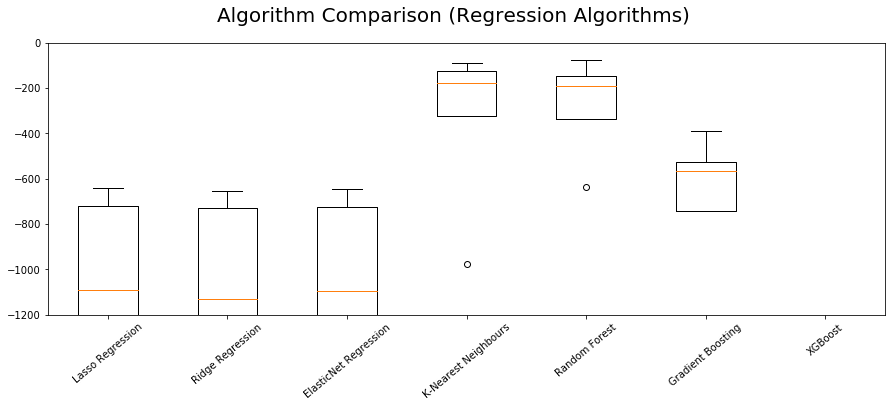

In [219]:
# Compare Algorithms
fig = plt.figure(figsize=(15,5))
fig.suptitle('Algorithm Comparison (Regression Algorithms)',fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(reg_results)
ax.set_xticklabels(reg_names,rotation=40)
ax.set_ylim(top=0, bottom=-1200)
plt.show()

K-Nearest Neighbours produces the lowest negative mean squared error, hence will be the model selected for the classification.

In [118]:
#KNN Model
st=time.time()
reg_knn = MultiOutputRegressor(KNeighborsRegressor())
reg_knn.fit(train[[x for x in train.columns if 'WAP' in x]], train[['LATITUDE','LONGITUDE']].values)
reg_preds = reg_knn.predict(test[[x for x in train.columns if 'WAP' in x]])

rsq = r2_score(test[['LATITUDE','LONGITUDE']].values, reg_preds)
print('R-squared score: {:.4f}'.format(rsq))
print('Mean Squared Error:')
ll_mse = dict(zip(['Latitude', 'Longitude'], mean_squared_error(test[['LATITUDE','LONGITUDE']].values, reg_preds, multioutput='raw_values')))
for k, v in ll_mse.items():
    print('\t{}: {:.2f}'.format(k, v))
print("\tTime elapsed: {:.2f} seconds".format(time.time()-st))

R-squared score: 0.9696
Mean Squared Error:
	Latitude: 206.76
	Longitude: 272.66
	Time elapsed: 22.44 seconds


In [120]:
#Random Forest Model
st=time.time()
reg_RF = MultiOutputRegressor(RandomForestRegressor())
reg_RF.fit(train[[x for x in train.columns if 'WAP' in x]], train[['LATITUDE','LONGITUDE']].values)
reg_preds_RF = reg_RF.predict(test[[x for x in train.columns if 'WAP' in x]])

rsq_RF = r2_score(test[['LATITUDE','LONGITUDE']].values, reg_preds_RF)
print('R-squared score: {:.4f}'.format(rsq_RF))
print('Mean Squared Error:')
ll_mse_RF = dict(zip(['Latitude', 'Longitude'], mean_squared_error(test[['LATITUDE','LONGITUDE']].values, reg_preds_RF, multioutput='raw_values')))
for k, v in ll_mse_RF.items():
    print('\t{}: {:.2f}'.format(k, v))
print("\tTime elapsed: {:.2f} seconds".format(time.time()-st))

R-squared score: 0.9739
Mean Squared Error:
	Latitude: 177.23
	Longitude: 236.41
	Time elapsed: 106.86 seconds


Although the R-squared score is very close to 1, a more intuitive measure of the results must be calculated to represent accuracy.

The distance between the predicted and actual long-lat can be calculated given these assumptions:

-    Longitude and Latitude are actually Northing and Easting coordinates (respectively)
-    Given that no UTM Zone is provided, the coordinates are assumed to be on a simple grid
-    Distance between 2 points is calculated by applying the Pythagoras theorem
-    Unit of distance = meters (m)

In [122]:
## Calculating distance        
def pythagoras(long1, long2, lat1, lat2):
    import math
    a = abs(long1-long2)**2
    b = abs(lat1-lat2)**2
    return math.sqrt(a+b)

In [123]:
#KNN Model
test_sub = pd.concat([test[['LATITUDE','LONGITUDE', 'BUILDINGID', 'FLOOR']], 
                     pd.DataFrame(columns=['pred_lat','pred_long'], data = reg_preds)],axis=1)
test_sub['dist_error'] = test_sub.apply(lambda row: pythagoras(row['LONGITUDE'], row['pred_long'], row['LATITUDE'], row['pred_lat']),axis=1)

org_ar = test_sub['dist_error'].mean()
print('On average, the KNN model is accurate up to {:.2f}m radius.'.format(org_ar))

On average, the KNN model is accurate up to 13.15m radius.


In [137]:
#Random Forest Model
test_sub_RF = pd.concat([test[['LATITUDE','LONGITUDE', 'BUILDINGID', 'FLOOR']], 
                     pd.DataFrame(columns=['pred_lat','pred_long'], data = reg_preds_RF)],axis=1)
test_sub_RF['dist_error'] = test_sub_RF.apply(lambda row: pythagoras(row['LONGITUDE'], row['pred_long'], \
                                                                    row['LATITUDE'],   row['pred_lat']),axis=1)

org_ar_RF = test_sub_RF['dist_error'].mean()
print('On average, the Random Forest model is accurate up to {:.2f}m radius.'.format(org_ar_RF))

On average, the Random Forest model is accurate up to 14.28m radius.


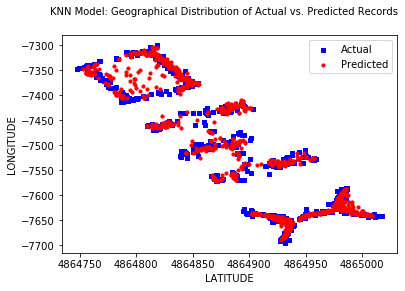

In [138]:
#KNN Model
fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.suptitle('KNN Model: Geographical Distribution of Actual vs. Predicted Records',fontsize=10)
ax1.scatter(test_sub['LATITUDE'], test_sub['LONGITUDE'], s=10, c='b', marker="s", label='Actual')
ax1.scatter(test_sub['pred_lat'],test_sub['pred_long'], s=10, c='r', marker="o", label='Predicted')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE')
plt.legend(loc='upper right')
plt.show()

For KNN Model
- The bottom-most building has the most accurately predicted locations
- In contrast, the top-most building has quite a fair amount of predicted records showing up in the middle area of the building which is empty / not accessible by foot traffic - unable to predict as accurately due to building architecture

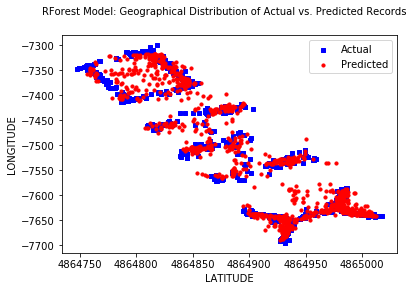

In [140]:
#Random Forest Model
fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.suptitle('RForest Model: Geographical Distribution of Actual vs. Predicted Records',fontsize=10)
ax1.scatter(test_sub_RF['LATITUDE'], test_sub_RF['LONGITUDE'], s=10, c='b', marker="s", label='Actual')
ax1.scatter(test_sub_RF['pred_lat'],test_sub_RF['pred_long'], s=10, c='r', marker="o", label='Predicted')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE')
plt.legend(loc='upper right')
plt.show()

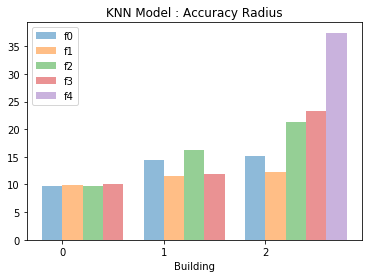

           dist_error                      
BUILDINGID          0          1          2
FLOOR                                      
0            9.669896  14.357701  15.234403
1            9.947225  11.488159  12.241960
2            9.812975  16.237228  21.386052
3           10.000940  11.981848  23.277227
4            0.000000   0.000000  37.442252


In [141]:
#KNN Model
dist_error = test_sub.groupby(['BUILDINGID', 'FLOOR']).dist_error.mean().reset_index().\
                    pivot(index='FLOOR',columns='BUILDINGID').fillna(0)

barWidth = 0.2
building_num = train_set["BUILDINGID"].sort_values(ascending=True).unique()
f1 = building_num
f2 = [x + barWidth for x in f1]
f3 = [x + barWidth for x in f2]
f4 = [x + barWidth for x in f3]
f5 = [x + barWidth for x in f4]
plt.bar(f1, dist_error.loc[0,:], width = barWidth, alpha=0.5, label='f0')
plt.bar(f2, dist_error.loc[1,:], width = barWidth, alpha=0.5, label='f1')
plt.bar(f3, dist_error.loc[2,:], width = barWidth, alpha=0.5, label='f2')
plt.bar(f4, dist_error.loc[3,:], width = barWidth, alpha=0.5, label='f3')
plt.bar(f5, dist_error.loc[4,:], width = barWidth, alpha=0.5, label='f4')
plt.legend()
plt.xlabel("Building")
plt.ylabel("")
plt.title('KNN Model : Accuracy Radius')
r = range(len(building_num))
plt.xticks([r + barWidth / 2 for r in range(len(num_floors_buildings_records.loc[0,:]))], ['0', '1', '2'])

plt.show()
print(dist_error)

Based on the breakdown of accuracy by building & floor, the top-most building in the scatter plot is most likely Building 2, with the highest concentration of inaccuracy from Floor 4 records.

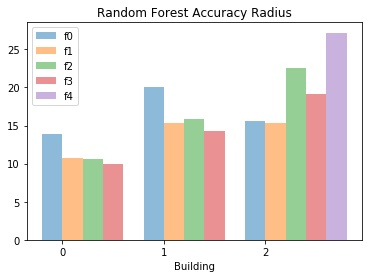

           dist_error                      
BUILDINGID          0          1          2
FLOOR                                      
0           13.894678  20.040718  15.615869
1           10.694859  15.292206  15.379802
2           10.615049  15.883853  22.551263
3            9.917153  14.287241  19.081135
4            0.000000   0.000000  27.182862


In [149]:
#Random Forest Model
dist_error_RF = test_sub_RF.groupby(['BUILDINGID', 'FLOOR']).dist_error.mean().reset_index().\
                    pivot(index='FLOOR',columns='BUILDINGID').fillna(0)

barWidth = 0.2
building_num = train_set["BUILDINGID"].sort_values(ascending=True).unique()
f1 = building_num
f2 = [x + barWidth for x in f1]
f3 = [x + barWidth for x in f2]
f4 = [x + barWidth for x in f3]
f5 = [x + barWidth for x in f4]
plt.bar(f1, dist_error_RF.loc[0,:], width = barWidth, alpha=0.5, label='f0')
plt.bar(f2, dist_error_RF.loc[1,:], width = barWidth, alpha=0.5, label='f1')
plt.bar(f3, dist_error_RF.loc[2,:], width = barWidth, alpha=0.5, label='f2')
plt.bar(f4, dist_error_RF.loc[3,:], width = barWidth, alpha=0.5, label='f3')
plt.bar(f5, dist_error_RF.loc[4,:], width = barWidth, alpha=0.5, label='f4')
plt.legend()
plt.xlabel("Building")
plt.ylabel("")
plt.title('Random Forest Accuracy Radius')
r = range(len(building_num))
plt.xticks([r + barWidth / 2 for r in range(len(num_floors_buildings_records.loc[0,:]))], ['0', '1', '2'])

plt.show()
print(dist_error_RF)

In [277]:
#se_corr=np.corrcoef([item for sublist in signal_fb.values.tolist() for item in sublist], [item for sublist in dist_error.values.tolist() for item in sublist])[0,1]
#print('Correlation coefficient between Accuracy Radius and Average Max Signal Strength: {:.4f}'.format(se_corr))

### Model improvements
Given the current accuracy radius of 13.15 metres, the current K-Nearest Neighbours model can be further improved by changing the K value.

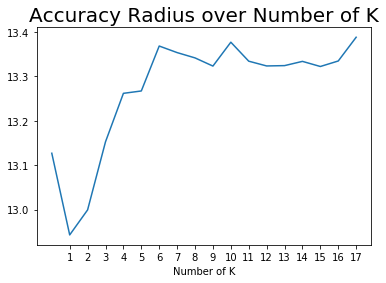

464.0675928592682

In [278]:
k_results = []
st=time.time()
for k in np.arange(2, 20):
    reg_knn_test = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=k))
    reg_knn_test.fit(train[[x for x in train.columns if 'WAP' in x]], train[['LATITUDE','LONGITUDE']].values)
    reg_preds_test = reg_knn_test.predict(test[[x for x in train.columns if 'WAP' in x]])
    temp_df = pd.concat([test_sub[['LATITUDE','LONGITUDE']], 
                          pd.DataFrame(columns=['pred_lat_tuned','pred_long_tuned'], data = reg_preds_test)],axis=1)
    temp_df['dist_error_tuned'] = temp_df.apply(lambda row: pythagoras(row['LONGITUDE'], row['pred_long_tuned'], row['LATITUDE'], row['pred_lat_tuned']),axis=1)
    k_results.append(temp_df['dist_error_tuned'].mean())

plt.plot(k_results)
plt.title('Accuracy Radius over Number of K', fontsize=20)
plt.xlabel('Number of K')
plt.xticks(range(1,len(k_results)),label=np.arange(2, 20))
plt.show()
time.time()-st

Given that there are 3 buildings, k = 3 is selected to tune the model and increase the accuracy.

In [279]:
reg_knn_tuned = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=3))
reg_knn_tuned.fit(train[[x for x in train.columns if 'WAP' in x]], train[['LATITUDE','LONGITUDE']].values)
reg_preds_tuned = reg_knn_tuned.predict(test[[x for x in train.columns if 'WAP' in x]])

new_rsq = r2_score(test[['LATITUDE','LONGITUDE']].values, reg_preds_tuned)
print('R-squared score: {:.4f}'.format(new_rsq))
print('Uplift in R-squared score: {:.2f}%'.format((new_rsq-rsq)/rsq*100))
print()
print('Mean Squared Error:')
ll_mse_tuned = dict(zip(['Latitude', 'Longitude'], mean_squared_error(test[['LATITUDE','LONGITUDE']].values, reg_preds_tuned, multioutput='raw_values')))
for k, v in ll_mse_tuned.items():
    print('\t{}: {:.2f}'.format(k, v))
print('Uplift in Mean Squared Error:')
for k, v in ll_mse_tuned.items():
    uplift = (ll_mse[k]-v)/ll_mse[k]
    print('\t{}: {:.2f}%'.format(k, (uplift*100)))

R-squared score: 0.9722
Uplift in R-squared score: 0.27%

Mean Squared Error:
	Latitude: 194.12
	Longitude: 234.70
Uplift in Mean Squared Error:
	Latitude: 6.11%
	Longitude: 13.92%


In [280]:
test_sub = pd.concat([test_sub[['LATITUDE','LONGITUDE', 'BUILDINGID', 'FLOOR', 'pred_lat', 'pred_long']], 
                     pd.DataFrame(columns=['pred_lat_tuned','pred_long_tuned'], data = reg_preds_tuned)],axis=1)
test_sub['dist_error_tuned'] = test_sub.apply(lambda row: pythagoras(row['LONGITUDE'], row['pred_long_tuned'], row['LATITUDE'], row['pred_lat_tuned']),axis=1)

In [281]:
tuned_ar = test_sub['dist_error_tuned'].mean()
print('On average, the current model is accurate up to {:.2f}m radius ({:.2f}% improvement).'.format(tuned_ar, ((org_ar-tuned_ar)/org_ar*100)))

On average, the current model is accurate up to 12.94m radius (1.59% improvement).


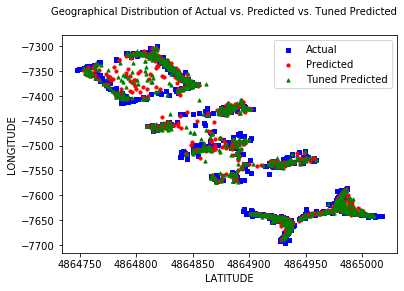

In [284]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.suptitle('Geographical Distribution of Actual vs. Predicted vs. Tuned Predicted',fontsize=10)
ax1.scatter(test_sub['LATITUDE'], test_sub['LONGITUDE'], s=10, c='b', marker="s", label='Actual')
ax1.scatter(test_sub['pred_lat'],test_sub['pred_long'], s=10, c='r', marker="o", label='Predicted')
ax1.scatter(test_sub['pred_lat_tuned'],test_sub['pred_long_tuned'], s=10, c='g', marker="^", label='Tuned Predicted')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE')
plt.legend(loc='upper right')
plt.show()